In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, DivergingNorm
import matplotlib.colors as colors
import qcodes as qc
import qcodes.instrument_drivers.nplab_drivers as npd
from scipy.optimize import curve_fit
from scipy.interpolate import interp2d, interp1d
from os import path
import colorcet as cc   # install quickly with "conda install colorcet"
from scipy.interpolate import RectBivariateSpline
from matplotlib import ticker
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
from lmfit import Model

In [2]:
cd ..

/Users/robertpolski/Documents/NPGroupResearch/Measurements/Triton/qcodes_data


In [3]:
qc.DataSet.default_io.base_location = path.abspath('.')
figfile = path.abspath('.') + '/Figures/200129_W5_BKTAnalysis/'

In [4]:
font = {
                'family': 'Arial',
                'size': 12,
                'serif': 'Times',
                'sans-serif': 'Arial'
            }

plt.rc('font', **font)

In [5]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'svg'

In [4]:
# %matplotlib widget

In [98]:
V0 = 0.34
sl = 12.2
b = -V0*sl
Vfn = -4.87
C = sl*1.602e-19**2/6.626e-34
dBN = 3*8.85e-12/C
print('effective capacitance: {:.4e}'.format(C))
print('effective hBN thickness: {:.1f} nm'.format(dBN*10**9))

# actually, take these values from the peaks at somewhat high field, and they seem more consistent
Vgatefull = (Vfp - Vfn)/2  # take the average of the positive and negative sides, since they vary slightly
print('Full filling voltage difference: {}'.format(Vgatefull))
nfull = Vgatefull*C/1.602e-19/10**4
print(nfull/10**12) #10**12 cm^-2
a = 0.246e-9

theta = np.sqrt(np.sqrt(3)*nfull*10**4*a**2/8)*180/np.pi
print('theta: ', theta)

effective capacitance: 4.7253e-04
effective hBN thickness: 56.2 nm


NameError: name 'Vfp' is not defined

In [6]:
dbkt0 = qc.load_data('data/2020-03-02/#004_W5_BTKbasetemp_865_40-39_830_39-38_1nA_3p4vbg_18-51-50')
dbkt1 = qc.load_data('data/2020-03-02/#005_W5_BKT50mKto1K_865_40-39_830_39-38_1nA_3p4vbg_19-12-12')
dbkt2 = qc.load_data('data/2020-03-03/#001_W5_BKT1Kto1p4K_865_40-39_830_39-38_1nA_3p4vbg_01-20-28')
dbkt3 = qc.load_data('data/2020-03-03/#002_W5_BKT1p5Kto2K_865_40-39_830_39-38_1nA_3p4vbg_02-46-52')

In [7]:
dbkt1.triton_pid_setpoint_set

DataArray[20]: triton_pid_setpoint_set
array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [8]:
dbkt2.triton_pid_setpoint_set

DataArray[5]: triton_pid_setpoint_set
array([1. , 1.1, 1.2, 1.3, 1.4])

In [9]:
dvdibkt = np.vstack((dbkt0.lockin865_X[:], dbkt1.lockin865_X[:, :], dbkt2.lockin865_X[1:, :], dbkt3.lockin865_X[:, :]))/1e-9
ibkt = dbkt0.srframe_volt_p5_set[:]*100e-9
vbkt = npd.iv_from_dvdi(dvdibkt, ibkt)
Tbkt = np.concatenate(([0.025], dbkt1.triton_pid_setpoint_set[:], dbkt2.triton_pid_setpoint_set[1:], dbkt3.triton_pid_setpoint_set[:]))

In [15]:
Tbkt[N]

0.85

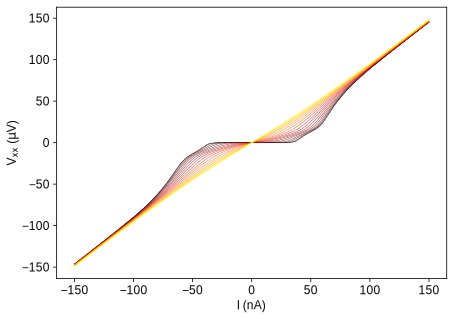

In [20]:
N = len(Tbkt)-12 - 1
cs = cc.cm.linear_kry_0_97_c73([i/(N - 1) for i in range(N)])

plt.figure(figsize=(7, 5))
for i in range(N):
    plt.plot(ibkt*1e9, vbkt[1+i, :]*1e6, lw=0.4, color=cs[i], label=f'{Tbkt[i+1]}')
    
plt.xlabel('I (nA)')
plt.ylabel('V$_{xx}$ ($\mu$V)')
# plt.legend()

# plt.savefig(figfile + 'W5_40-39_BKT_iv_linear.svg', dpi=300, bbox_inches='tight')

(5, 150)

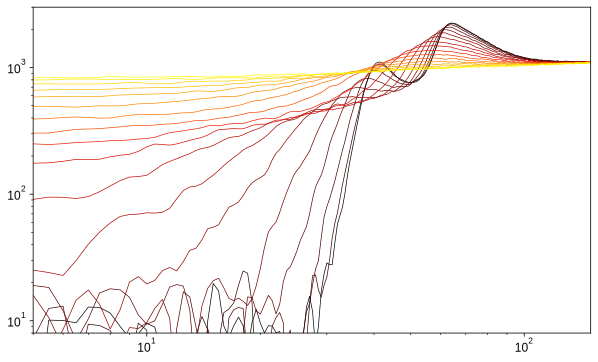

In [11]:
N = len(Tbkt)-13
cs = cc.cm.linear_kry_0_97_c73([i/(N - 1) for i in range(N)])

plt.figure(figsize=(10, 6))
for i in range(N):
    plt.loglog(ibkt*1e9, gaussian_filter(dvdibkt[i, :], 1), lw=0.7, color=cs[i])
    
plt.ylim((8, 3e3))
plt.xlim((5, 150))

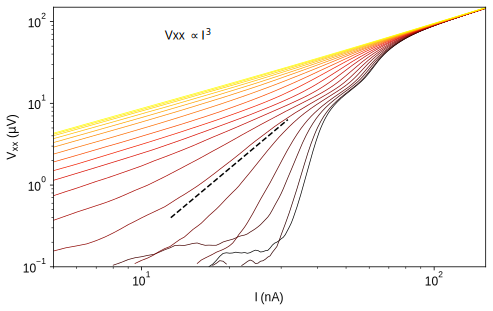

In [35]:
N = len(Tbkt)-12 - 1
cs = cc.cm.linear_kry_0_97_c73([i/(N - 1) for i in range(N)])

xmin, xmax = 5, 150
ymin, ymax = 1e-1, 1.5e2

plt.figure(figsize=(7, 4.5))
for i in range(N):
    plt.loglog(np.ma.masked_outside(ibkt*1e9, xmin, xmax), np.ma.masked_outside(1e6*vbkt[1+i, :], ymin, ymax), lw=0.7, color=cs[i])

Ib = np.logspace(-7.9, -7.5, 100)
l1 = plt.loglog(Ib*1e9, 2e23*Ib**3, 'k--')

plt.axis((xmin, xmax, ymin, ymax))

plt.ylabel('V$_{xx}$ ($\mu$V)')
plt.xlabel('I (nA)')
plt.tight_layout()

s = 'Vxx $\propto I^3$'
plt.text(12, 60, s)

# plt.savefig(figfile + 'W5_40-39_BKTloglogIV.svg', dpi=300, bbox_inches='tight')

# BKT analysis on 39-38

In [84]:
dvdibkt2 = np.vstack((dbkt0.lockin830_X[:], dbkt1.lockin830_X[:, :], dbkt2.lockin830_X[1:, :], dbkt3.lockin830_X[:, :]))/1e-9
ibkt2 = dbkt0.srframe_volt_p5_set[:]*100e-9
vbkt2 = npd.iv_from_dvdi(dvdibkt, ibkt)
Tbkt2 = np.concatenate(([0.025], dbkt1.triton_pid_setpoint_set[:], dbkt2.triton_pid_setpoint_set[1:], dbkt3.triton_pid_setpoint_set[:]))

Text(0, 0.5, 'V$_{xx}$ ($\\mu$V)')

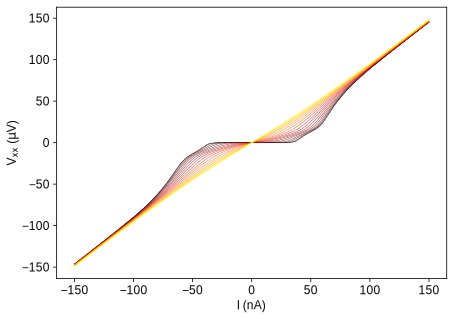

In [86]:
N = len(Tbkt)-12 - 1
cs = cc.cm.linear_kry_0_97_c73([i/(N - 1) for i in range(N)])

plt.figure(figsize=(7, 5))
for i in range(N):
    plt.plot(ibkt2*1e9, vbkt2[1+i, :]*1e6, lw=0.4, color=cs[i], label=f'{Tbkt[i+1]}')
    
plt.xlabel('I (nA)')
plt.ylabel('V$_{xx}$ ($\mu$V)')
# plt.legend()

# plt.savefig(figfile + 'W5_39-38_BKT_iv_linear.svg', dpi=300, bbox_inches='tight')

(5, 150)

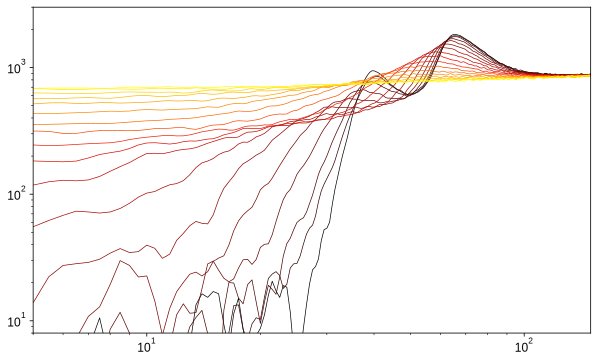

In [87]:
N = len(Tbkt)-13
cs = cc.cm.linear_kry_0_97_c73([i/(N - 1) for i in range(N)])

plt.figure(figsize=(10, 6))
for i in range(N):
    plt.loglog(ibkt2*1e9, gaussian_filter(dvdibkt2[i, :], 1), lw=0.7, color=cs[i])
    
plt.ylim((8, 3e3))
plt.xlim((5, 150))

Text(12, 60, 'Vxx $\\propto I^3$')

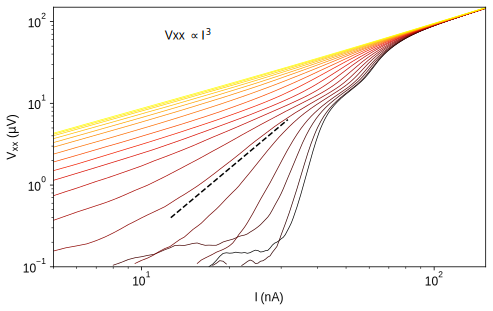

In [88]:
N = len(Tbkt)-12 - 1
cs = cc.cm.linear_kry_0_97_c73([i/(N - 1) for i in range(N)])

xmin, xmax = 5, 150
ymin, ymax = 1e-1, 1.5e2

plt.figure(figsize=(7, 4.5))
for i in range(N):
    plt.loglog(np.ma.masked_outside(ibkt2*1e9, xmin, xmax), np.ma.masked_outside(1e6*vbkt2[1+i, :], ymin, ymax), lw=0.7, color=cs[i])

Ib = np.logspace(-7.9, -7.5, 100)
l1 = plt.loglog(Ib*1e9, 2e23*Ib**3, 'k--')

plt.axis((xmin, xmax, ymin, ymax))

plt.ylabel('V$_{xx}$ ($\mu$V)')
plt.xlabel('I (nA)')
plt.tight_layout()

s = 'Vxx $\propto I^3$'
plt.text(12, 60, s)

# plt.savefig(figfile + 'W5_39-38_BKTloglogIV.svg', dpi=300, bbox_inches='tight')

# BKT analysis #2 at 3.9V

I realized that the rest of the temperature plots are currently made for 39-38 data, so use that here (lockin830)

In [47]:
db0 = qc.load_data('data/2020-03-04/#046_W5_BTKbasetemp_865_40-39_830_39-38_1nA_3p9vbg_18-51-43')
db1 = qc.load_data('data/2020-03-04/#047_W5_BKT50mKto1K_865_40-39_830_39-38_1nA_3p9vbg_19-14-40')
db2 = qc.load_data('data/2020-03-05/#001_W5_BKT1Kto1p4K_865_40-39_830_39-38_1nA_3p9vbg_00-39-52')
db3 = qc.load_data('data/2020-03-05/#002_W5_BKT1p5Kto2K_865_40-39_830_39-38_1nA_3p9vbg_02-00-45')

tempsb = np.concatenate(([0.025], db1.triton_pid_setpoint_set[:], db2.triton_pid_setpoint_set[1:], db3.triton_pid_setpoint_set[:]))
currb = db0.srframe_volt_p5_set[:]*10*1e-9
vb = npd.iv_from_dvdi(dvdib, currb)
dvdib = np.vstack((db0.lockin830_X[:], db1.lockin830_X[:, :], db2.lockin830_X[1:, :], db3.lockin830_X[:, :]))/1e-9

In [48]:
tempsb

array([0.025, 0.05 , 0.1  , 0.15 , 0.2  , 0.25 , 0.3  , 0.35 , 0.4  ,
       0.45 , 0.5  , 0.55 , 0.6  , 0.65 , 0.7  , 0.75 , 0.8  , 0.85 ,
       0.9  , 0.95 , 1.   , 1.1  , 1.2  , 1.3  , 1.4  , 1.5  , 1.6  ,
       1.7  , 1.8  , 1.9  , 2.   ])

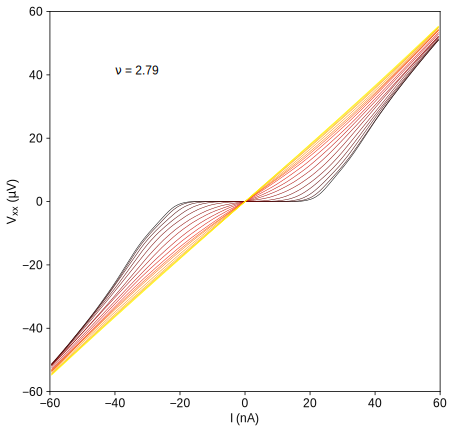

In [145]:
N = len(tempsb)-12 - 1
cs = cc.cm.linear_kry_0_97_c73([i/(N - 1) for i in range(N)])

xmin, xmax = -60, 60
ymin, ymax = -60, 60

plt.figure(figsize=(7, 7))
for i in range(N):
    plt.plot(np.ma.masked_outside(currb*1e9, xmin, xmax), np.ma.masked_outside(vb[1+i, :]*1e6, ymin, ymax), color=cs[i], lw=0.5, label=tempsb[1+i])
    
plt.axis((xmin, xmax, ymin, ymax))
plt.ylabel('V$_{xx}$ ($\mu$V)')
plt.xlabel('I (nA)')
plt.text(-40, 40, '$\\nu$ = 2.79')

# plt.savefig(figfile + 'W5_0p8_ivlinear.svg', dpi=300, bbox_inches='tight')

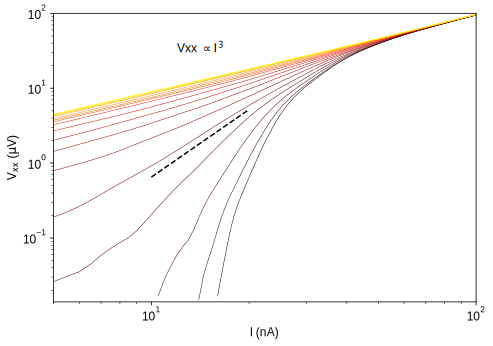

In [151]:
N = len(tempsb)-12 - 1
cs = cc.cm.linear_kry_0_97_c73([i/(N-1) for i in range(N)])

xmin, xmax = 5, 100
ymin, ymax = 1.4e-2, 1e2

plt.figure(figsize=(7, 5))
for i in range(N):
    plt.loglog(np.ma.masked_outside(currb*1e9, xmin, xmax), np.ma.masked_outside(vb[1+i, :]*1e6, ymin, ymax), color=cs[i], lw=0.5)
    
plt.axis((xmin, xmax, ymin, ymax))

Ib = np.logspace(-8, -7.7, 100)
l1 = plt.loglog(Ib*1e9, 6.5e23*Ib**3, 'k--')

plt.ylabel('V$_{xx}$ ($\mu$V)')
plt.xlabel('I (nA)')
plt.tight_layout()

s = 'Vxx $\propto I^3$'
plt.text(12, 30, s)

# plt.savefig(figfile + 'W5_0p8_nu2p79_loglogBKT.svg', dpi=300, bbox_inches='tight')

# Now a gate curve showing definite 0 resistance

In [89]:
# all at base temp, with sensors disconnected
dg1 = qc.load_data('data/2020-03-03/#004_W5_830_40-39_865_39-38_baseT_1nA_gatesweep_-0p8mT_sensitivity_100uV_10-08-22')
dg2 = qc.load_data('data/2020-03-03/#005_W5_830_40-39_865_39-38_baseT_1nA_gatesweep_-0p8mT_sensitivity_100uV_300ms_10-16-02')
dg3 = qc.load_data('data/2020-03-03/#006_W5_830_40-39_865_39-38_baseT_2nA_gatesweep_-0p8mT_sensitivity_100uV_300ms_10-24-10')
dg4 = qc.load_data('data/2020-03-03/#007_W5_830_40-39_865_39-38_baseT_0p5nA_gatesweep_-0p8mT_sensitivity_100uV_300ms_10-32-12')

In [142]:
np.interp(3.9, [V0 - 6/4*Vgatefull, V0 + 6/4*Vgatefull], [-6, 6])

2.7903381642512066

In [131]:
gg = dg1.srframe_volt_p1_set[:]
# convert to nu
V0 = 0.34 - 0.05
Vgatefull = 5.175000000000001
nug = np.interp(gg, [V0 - 6/4*Vgatefull, V0 + 6/4*Vgatefull], [-6, 6])

Rg1 = dg1.lockin865_X[:]/1e-9
Rg2 = dg2.lockin865_X[:]/1e-9
Rg3 = dg3.lockin865_X[:]/2e-9
Rg4 = dg4.lockin865_X[:]/0.5e-9

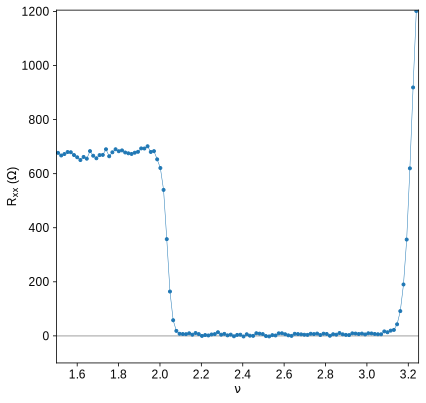

In [136]:
plt.figure(figsize=(6.5, 6.5))

xmin, xmax = 1.5, 3.25
ymin, ymax = -100, 1205
# plt.plot(gg, Rg1)
# plt.plot(gg, Rg2)
plt.plot(np.ma.masked_outside(nug, xmin, xmax), np.ma.masked_outside(Rg3, ymin, ymax), '.-', lw=0.5)
# plt.plot(gg, Rg4)
plt.axis((xmin, xmax, ymin, ymax))
plt.hlines(0, xmin, xmax, color='gray', alpha=0.5)

plt.xlabel('$\\nu$')
plt.ylabel('R$_{xx}$ ($\Omega$)')

# plt.savefig(figfile + 'W5_0p8_3938_baseT_SCgatesweep.svg', dpi=300, bbox_inches='tight')